In [1]:
# Libraries
using ScikitLearn;
using DataFrames;
using CSV;
using Random;
using Statistics;
using StatsPlots;
using Flux.Losses;
using Flux;

@sk_import impute: KNNImputer; # Imputation of missing values.
@sk_import svm: SVC;
@sk_import decomposition: PCA;
@sk_import tree: DecisionTreeClassifier;
@sk_import neighbors: KNeighborsClassifier;

include("utils/fluxANNs.jl"); # for ANN training with Flux
include("utils/evaluation.jl"); # for confusion matrix calculation and cross validation set partitioning
include("utils/preprocessing.jl"); # for normalization, one-hot encoding, holdout division
include("utils/training.jl"); # for crossvalidation methodology
include("utils/visualizations.jl"); # for plots

# Set seed
Random.seed!(10);

[ Info: Running `conda install -y -c anaconda conda` in root environment


Channels:
 - anaconda
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - conda


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            conda-forge/noarch::certifi-2024.8.30~ --> anaconda/linux-64::certifi-2024.8.30-py312h06a4308_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


[ Info: Running `conda install -y -c conda-forge 'libstdcxx-ng>=3.4,<13.0'` in root environment


Channels:
 - conda-forge
 - anaconda
Platform: linux-64
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/marcos/.julia/conda/3/x86_64

  added / updated specs:
    - libstdcxx-ng[version='>=3.4,<13.0']


The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            anaconda/linux-64::certifi-2024.8.30-~ --> conda-forge/noarch::certifi-2024.8.30-pyhd8ed1ab_0 



Preparing transaction: done
Verifying transaction: done
Executing transaction: done


# Hold-out partition

In [2]:
# loading the dataset
support2 = CSV.read("datasets/support2_cleaned.csv", DataFrame, delim = ',');

# fate: 0 = recovery, 1 = death at home, 2 = death at the hospital
support2[:, "fate"] = support2[:,"death"] + support2[:,"hospdead"];
target_cols = ["death", "hospdead", "fate"];

trainIndex, testIndex = holdOut(nrow(support2), 0.2);

trainInputs = Array(support2[trainIndex, Not(target_cols)]);
testInputs = Array(support2[testIndex, Not(target_cols)]);

# Imputation

In [3]:
imputer = KNNImputer(n_neighbors = 5);

trainInputs[:,1:32] = fit_transform!(imputer, trainInputs[:,1:32]);
testInputs[:,1:32] = imputer.transform(testInputs[:,1:32]);

# Visualizations

In [10]:
meanTrain, stdTrain = calculateZeroMeanNormalizationParameters(trainInputs[:,1:32]);
numInputs = normalizeZeroMean!(trainInputs[:,1:32], (meanTrain, stdTrain));

plot_correlations(numInputs);
savefig("plots/correlations.png");

# Train PCA on training dataset.
pca = PCA(2);
pcaInputs = fit_transform!(pca, numInputs);

# Draw results
draw_results(pcaInputs, trainTargets; colors=[:green,:red], target_names=["Survived", "Died"]);
savefig("plots/pca.png");

# Helper function for finding best performing model

In [4]:
function findBestModel(models, trainInputs, trainTargets, kFoldIndices)
    bestMetricYet = 0;
    bestModel = -1;
    
    for (modelType, paramList) in models
        cnt = 1;
        println();
        println("Training ", modelType, " models:");
        for params in paramList
            (accur, fScore), (stdAccur, stdFScore) = modelCrossValidation(modelType, params, trainInputs,
                                                                          trainTargets, kFoldIndices);
            println("Configuration ", cnt, ": ", params);
            println("Accuracy:", accur, ", stdDev:", stdAccur);
            println("F1-Score:", fScore, ", stdDev:", stdFScore);
            println();
            cnt += 1;
            #println(modelType, (accur, fScore), (stdAccur, stdFScore))
            if accur * fScore > bestMetricYet
                bestMetricYet = accur * fScore;
                bestModel = (modelType, params);
            end;
        end;
    end;
    
    return bestModel
end;

# Categorical approach

In [5]:
trainTargets = Array(support2[trainIndex, "fate"]);
testTargets = Array(support2[testIndex, "fate"]);

# Kfold
kFoldIndices = crossvalidation(trainTargets, 5);

- ANN

In [6]:
ANNparams = [Dict("topology" => [2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [2, 2], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [4, 4], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [8, 8], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1),
            Dict("topology" => [16, 16], "maxEpochs" => 500, "minLoss" => 0., "learningRate" => 0.01, 
                "maxEpochsVal" => 20, "validationRatio" => 0.1)]

models = [(:ANN, ANNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training ANN models:


┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 2, σ)   # 22 parameters
│   summary(x) = "10×5202 adjoint(::Matrix{Float64}) with eltype Float64"
└ @ Flux ~/.julia/packages/Flux/hiqg1/src/layers/stateless.jl:60


Configuration 1: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [2], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8083963284463966, stdDev:0.014199102550692259
F1-Score:0.8060711925118152, stdDev:0.014263505900807756

Configuration 2: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [4], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8072614280229342, stdDev:0.014997643381784597
F1-Score:0.8057108790043583, stdDev:0.015025052827598532

Configuration 3: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [8], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)
Accuracy:0.8080780276597862, stdDev:0.01384350468972902
F1-Score:0.8065997317745985, stdDev:0.014030811344058293

Configuration 4: Dict{String, Any}("maxEpochs" => 500, "learningRate" => 0.01, "topology" => [16], "validationRatio" => 0.1, "maxEpochsVal" => 20, "minLoss" => 0.0)

- SVM

In [7]:
SVMparams = [Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "linear", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "rbf", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "sigmoid", "degree" => 0, "gamma" => "scale", "C" => 1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 0.1),
            Dict("kernel" => "poly", "degree" => 3, "gamma" => "scale", "C" => 1)]

models = [(:SVM, SVMparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training SVM models:
Configuration 1: Dict{String, Any}("C" => 0.1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8061121318164328, stdDev:0.01242686614476141
F1-Score:0.8058354327643616, stdDev:0.012548031988736738

Configuration 2: Dict{String, Any}("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)
Accuracy:0.8121999918149132, stdDev:0.015227179373101543
F1-Score:0.8120205744345836, stdDev:0.01525357383567451

Configuration 3: Dict{String, Any}("C" => 0.1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.7986389431125472, stdDev:0.011458629874001158
F1-Score:0.7978785725067742, stdDev:0.011461499893315677

Configuration 4: Dict{String, Any}("C" => 1, "kernel" => "rbf", "gamma" => "scale", "degree" => 0)
Accuracy:0.8073579025401172, stdDev:0.013089121025221535
F1-Score:0.8059175344007409, stdDev:0.01338571910905681

Configuration 5: Dict{String, Any}("C" => 0.1, "kernel" => "sigmoid", "gamma" => "scale", "degree" => 0)
Accuracy:0

- DecisionTree

In [12]:
DTreeParams = [Dict("maxDepth" => 4), Dict("maxDepth" => 8), Dict("maxDepth" => 16),
                Dict("maxDepth" => 32), Dict("maxDepth" => 64), Dict("maxDepth" => 128)]

models = [(:DTree, DTreeParams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");
println(params);


Training DTree models:
Configuration 1: Dict("maxDepth" => 4)
Accuracy:0.8242464992017021, stdDev:0.009680393253705498
F1-Score:0.8201326352040036, stdDev:0.0111022120671285

Configuration 2: Dict("maxDepth" => 8)
Accuracy:0.8162201564003817, stdDev:0.01619230083778309
F1-Score:0.8140456692281607, stdDev:0.01700940116864918

Configuration 3: Dict("maxDepth" => 16)
Accuracy:0.7867413807053378, stdDev:0.011785139499927147
F1-Score:0.7867250951928486, stdDev:0.01148928010159594

Configuration 4: Dict("maxDepth" => 32)
Accuracy:0.7809295715714306, stdDev:0.009554228103285302
F1-Score:0.7809656171584581, stdDev:0.009494150244711442

Configuration 5: Dict("maxDepth" => 64)
Accuracy:0.7809295715714306, stdDev:0.009554228103285302
F1-Score:0.7809656171584581, stdDev:0.009494150244711442

Configuration 6: Dict("maxDepth" => 128)
Accuracy:0.7809295715714306, stdDev:0.009554228103285302
F1-Score:0.7809656171584581, stdDev:0.009494150244711442

Best model is DTree with hyperparameters:
Dict("maxD

- KNN

In [9]:
KNNparams = [Dict("k" => 3), Dict("k" => 6), Dict("k" => 12),
            Dict("k" => 24), Dict("k" => 48), Dict("k" => 96)]

models = [(:KNN, KNNparams)];

(modelType, params) = findBestModel(models, trainInputs, trainTargets, kFoldIndices);
println("Best model is ", modelType, " with hyperparameters:");

println(params);


Training KNN models:
Configuration 1: Dict("k" => 3)
Accuracy:0.7675055887344995, stdDev:0.017544684925476884
F1-Score:0.7666030787135351, stdDev:0.017682985853871534

Configuration 2: Dict("k" => 6)
Accuracy:0.7872953000169017, stdDev:0.011411894739570197
F1-Score:0.7862048793141947, stdDev:0.011385734127817657

Configuration 3: Dict("k" => 12)
Accuracy:0.789231197769446, stdDev:0.010935732595464044
F1-Score:0.787848939956688, stdDev:0.011243929454209866

Configuration 4: Dict("k" => 24)
Accuracy:0.7914439116006926, stdDev:0.01244331114873614
F1-Score:0.7902821713728287, stdDev:0.012664015543440859

Configuration 5: Dict("k" => 48)
Accuracy:0.7925498381165117, stdDev:0.011568740439323126
F1-Score:0.7915687715759092, stdDev:0.011615510547586432

Configuration 6: Dict("k" => 96)
Accuracy:0.7889509343825305, stdDev:0.01425244521689101
F1-Score:0.7877436656875003, stdDev:0.01431897006431267

Best model is KNN with hyperparameters:
Dict("k" => 48)


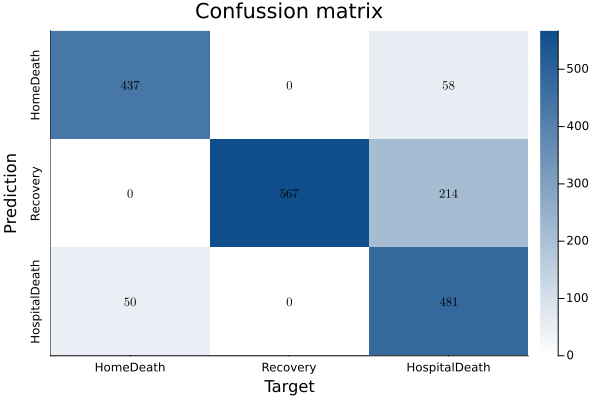

In [13]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

# normalization and validation set computation if needed
valRatio = if modelType != :ANN 0. else params["validationRatio"] end
train, val, test = prepareDataForFitting(train, test, valRatio)

classes = unique(trainTargets)
matAndMetrics = fitAndConfusion(modelType, params, train, val, test, classes)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end


class_map = Dict(0 => "Recovery", 1 => "HomeDeath", 2 => "HospitalDeath")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)

- Ensemble

In [14]:
@sk_import ensemble:StackingClassifier

# An ANN flux model cannot be included in a Scikit ensemble due to PyCall wrapping issues
estimators = [:KNN, :DTree, :SVM]
params = []
DTreeParams = Dict("maxDepth" => 4)
KNNparams = Dict("k" => 48)
SVMparams = Dict("C" => 1, "kernel" => "linear", "gamma" => "scale", "degree" => 0)


params = Vector{Dict}([KNNparams, DTreeParams, SVMparams])

means, stds = trainClassEnsemble(estimators, params, (trainInputs, trainTargets),
                   crossvalidation(trainTargets, 5))

println("Mean accuracy and F-Score: ", means)
println("Standard deviations in accuracy and F-Score: ", stds)

Mean accuracy and F-Score: 

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc9d0591120>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

[0.8548289937989683 0.8516911488428134]
Standard deviations in accuracy and F-Score: [0.009697286054708832 0.00973569427704344]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc9d05e6ac0>
Traceback (most recent call last):
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/marcos/anaconda3/lib/python3.12/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attr

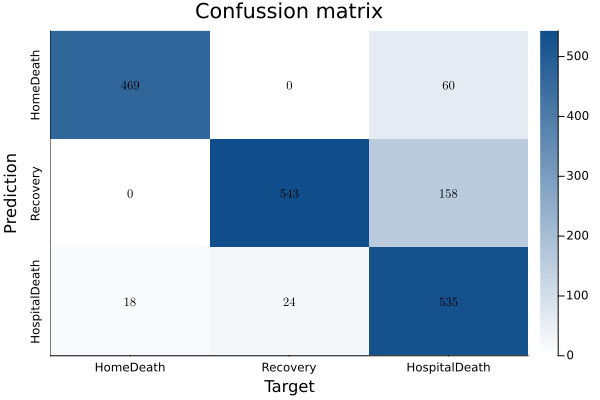

In [15]:
using Plots;

# train best model with all paterns and build confusion matrix with all patterns
train = (trainInputs, trainTargets); test = (testInputs, testTargets);

ensemble = fitEnsemble(train, estimators, params)

classes = unique(trainTargets)
matAndMetrics = confusionMatrix(predict(ensemble, testInputs), testTargets; weighted=true)
confMat = matAndMetrics[8]

function displayConfMat(confMat, classes)
    (n,m) = size(confMat)
    heatmap(confMat, fc=cgrad([:white,:dodgerblue4]), xticks=(1:m,classes), yrot=90, yticks=(1:m,classes), 
            title="Confussion matrix", xlabel="Target", ylabel="Prediction", yflip=true)
    # add number of coincidences in each cell
    annotate!([(j, i, text(round(confMat[i,j]), 8,"Computer Modern",:black)) for i in 1:n for j in 1:m])
end

class_map = Dict(0 => "Recovery", 1 => "HomeDeath", 2 => "HospitalDeath")
classNames = [class_map[class] for class in classes]
displayConfMat(confMat, classNames)